In [2]:
# Install required libraries
!pip install torch torchvision
!pip install diffusers  # For samplers and schedulers
!pip install timm       # For pre-trained ViT/DINO models
!pip install accelerate # For easier training and mixed precision

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

# Define the classes we want
CLASSES_TO_USE = ['cat', 'dog']
CLASS_LABELS = [3, 5]

# --- VAE & Pre-trained Encoder Setup ---
# REG requires a VAE to encode images into latents and a
# pre-trained encoder (like DINO) to get class tokens.
# For simplicity in this project, we will skip the VAE and
# operate directly on the 32x32 images. We will also
# use standard class embeddings instead of DINO tokens
# to make the project feasible without ImageNet pre-training.
#
# NOTE: A true-to-paper implementation would use a VAE
# and a DINOv2 model to extract class tokens.

# Standard CIFAR-10 transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

# Load the full CIFAR-10 training set
full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Filter for 'cat' and 'dog'
indices = []
for i, (img, label) in enumerate(full_train_dataset):
    if label in CLASS_LABELS:
        indices.append(i)

# Create a subset
train_dataset = Subset(full_train_dataset, indices)

# Create the DataLoader
# Use batch_size 256 as requested
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"Filtered dataset size: {len(train_dataset)}")

100%|██████████| 170M/170M [00:03<00:00, 46.5MB/s]


Filtered dataset size: 10000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
import torch.nn as nn
import math

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

class SiTBlock(nn.Module):
    """
    A block of the Scalable Image Transformer (SiT).
    Uses adaptive LayerNorm (adaLN-Zero) as suggested by DiT.
    """
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        # adaLN-Zero modulation
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )
        self.adaLN_modulation.apply(lambda m: isinstance(m, nn.Linear) and nn.init.zeros_(m.weight))

    def forward(self, x, t_emb):
        # t_emb is the time embedding
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = \
            self.adaLN_modulation(t_emb).chunk(6, dim=1)

        # Self-Attention
        x_norm1 = self.norm1(x)
        x_norm1 = x_norm1 * (1 + scale_msa[:, None]) + shift_msa[:, None]
        attn_out, _ = self.attn(x_norm1, x_norm1, x_norm1, need_weights=False)
        x = x + gate_msa[:, None] * attn_out

        # MLP
        x_norm2 = self.norm2(x)
        x_norm2 = x_norm2 * (1 + scale_mlp[:, None]) + shift_mlp[:, None]
        mlp_out = self.mlp(x_norm2)
        x = x + gate_mlp[:, None] * mlp_out

        return x

In [5]:
class SiT_REG(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3,
                 hidden_size=384, depth=12, num_heads=6, num_classes=2):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.hidden_size = hidden_size

        # 1. Image Patch Embedding
        self.patch_embed = nn.Conv2d(
            in_channels, hidden_size,
            kernel_size=patch_size, stride=patch_size
        )

        # 2. Positional Embedding for image patches
        self.pos_embed = nn.Parameter(
            torch.randn(1, self.num_patches, hidden_size)
        )

        # 3. REG: Class Token Embedding
        # We need one learnable embedding for 'cat' and one for 'dog'
        # We also need a positional embedding for this class token
        self.class_embed = nn.Embedding(num_classes, hidden_size)
        self.class_pos_embed = nn.Parameter(torch.randn(1, 1, hidden_size))

        # 4. Timestep Embedding
        self.time_embed = TimestepEmbedder(hidden_size)

        # 5. Transformer Blocks
        self.blocks = nn.ModuleList([
            SiTBlock(hidden_size, num_heads) for _ in range(depth)
        ])

        # 6. Output Layer
        # The model needs to predict the velocity v, which has the
        # same shape as the input (image + class token).
        # We first normalize, then project back.
        self.norm_out = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.proj_out = nn.Linear(hidden_size, (patch_size ** 2 * in_channels) + hidden_size, bias=True)
        self.proj_out_img = nn.Linear(hidden_size, patch_size ** 2 * in_channels, bias=True)
        self.proj_out_class = nn.Linear(hidden_size, hidden_size, bias=True)


    def unpatchify(self, x_patches):
        # x_patches: (B, num_patches, patch_size**2 * C)
        B, N, D_patch = x_patches.shape
        C = 3
        P = self.patch_size
        H = W = int(N**0.5)

        x = x_patches.reshape(B, H, W, P, P, C)
        x = x.permute(0, 5, 1, 3, 2, 4) # (B, C, H, P, W, P)
        x = x.reshape(B, C, H * P, W * P) # (B, C, ImgSize, ImgSize)
        return x

    def forward(self, z, t, c):
        # z: (B, C, H, W) - noised image
        # t: (B,) - timesteps
        # c: (B, hidden_size) - noised class token

        # Embed time
        t_emb = self.time_embed(t) # (B, hidden_size)

        # Embed image patches
        z_patches = self.patch_embed(z) # (B, hidden_size, H/P, W/P)
        z_patches = z_patches.flatten(2).transpose(1, 2) # (B, num_patches, hidden_size)
        z_patches = z_patches + self.pos_embed # (B, num_patches, hidden_size)

        # Add class token positional embedding
        c = c + self.class_pos_embed # (B, 1, hidden_size)

        # [REG] Concatenate class token and image tokens
        x = torch.cat((c, z_patches), dim=1) # (B, 1 + num_patches, hidden_size)

        # Run through transformer blocks
        for block in self.blocks:
            x = block(x, t_emb)

        # Final normalization
        x = self.norm_out(x)

        # Split back into class and image predictions
        c_pred, z_patches_pred = x[:, :1], x[:, 1:]

        # Project to output shapes
        v_pred_class = self.proj_out_class(c_pred) # (B, 1, hidden_size)
        v_pred_patches = self.proj_out_img(z_patches_pred) # (B, num_patches, P*P*C)

        # Unpatchify the image prediction
        v_pred_img = self.unpatchify(v_pred_patches) # (B, C, H, W)

        return v_pred_img, v_pred_class.squeeze(1)

In [6]:
from diffusers import DDPMScheduler

# 1. Setup the Scheduler
num_train_timesteps = 1000 # Standard DDPM, sampler will use 250
scheduler = DDPMScheduler(
    num_train_timesteps=num_train_timesteps,
    beta_schedule="linear",
    prediction_type="velocity"  # <-- This sets v-prediction!
)

# 2. Setup Model and Optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model Scaling:
# 'small' vs 'medium' is defined by depth and hidden_size
# Small model (example)
model_small = SiT_REG(
    img_size=32, patch_size=4, hidden_size=384, depth=12, num_heads=6
).to(device)

# Medium model (example)
# model_medium = SiT_REG(
#     img_size=32, patch_size=4, hidden_size=512, depth=16, num_heads=8
# ).to(device)

model = model_small
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.0)

# Get the learnable class embeddings
class_embeddings = model.class_embed.weight # (2, hidden_size)

In [8]:
import torch.nn.functional as F

num_epochs = 100 # Adjust as needed
reg_loss_weight = 0.1 # Hyperparameter (lambda) to balance the losses

model.train()
for epoch in range(num_epochs):
    for step, (batch_images, batch_labels) in enumerate(train_loader):
        # --- Prepare Data ---
        # 0. Remap labels from [3, 5] to [0, 1]
        labels = (batch_labels == 5).long().to(device)

        # 1. Get clean images (x0) and clean class tokens (c0)
        x0 = batch_images.to(device)
        c0 = class_embeddings[labels] # (B, hidden_size)

        # 2. Sample noise (one for image, one for class token)
        noise_z = torch.randn_like(x0)
        noise_c = torch.randn_like(c0)

        # 3. Sample timesteps
        t = torch.randint(0, scheduler.num_train_timesteps, (x0.shape[0],), device=device).long()

        # 4. [REG] Apply *synchronized* noise to both image and class token
        # This is the core of the REG technique
        xt = scheduler.add_noise(x0, noise_z, t)

        # We must noise the class token using the *same* schedule
        # scheduler.add_noise is: sqrt(alpha_prod) * x + sqrt(1 - alpha_prod) * noise
        sqrt_alpha_prod = scheduler.alphas_cumprod[t]**0.5
        sqrt_one_minus_alpha_prod = (1 - scheduler.alphas_cumprod[t])**0.5
        # Manually resize for broadcasting
        sqrt_alpha_prod = sqrt_alpha_prod.to(device).view(-1, 1)
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.to(device).view(-1, 1)

        ct = sqrt_alpha_prod * c0 + sqrt_one_minus_alpha_prod * noise_c

        # --- Get Model Prediction ---
        # 5. Predict the velocity (v) for both
        v_pred_img, v_pred_class = model(xt, t, ct.unsqueeze(1)) # Add seq dim for token

        # --- Calculate Loss ---
        # 6. Get the *target* velocity for both
        v_target_img = scheduler.get_velocity(x0, noise_z, t)
        v_target_class = scheduler.get_velocity(c0, noise_c, t)

        # 7. Compute the losses
        loss_img = F.mse_loss(v_pred_img, v_target_img)
        loss_class = F.mse_loss(v_pred_class, v_target_class)

        # 8. Total weighted loss
        loss = loss_img + reg_loss_weight * loss_class

        # --- Optimization ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f} | Img Loss: {loss_img.item():.4f} | Class Loss: {loss_class.item():.4f}")

    # --- End of Epoch: Sampling (Evaluation) ---
    # --- End of Epoch: Sampling (Evaluation) ---
    if epoch % 10 == 0:
        print("Sampling images...")
        model.eval()

        # Use the Euler–Maruyama sampler as requested
        from diffusers import EulerDiscreteScheduler

        # 1. FIX THE PREDICTION_TYPE ERROR
        # Copy the config and correct the typo ("velocity" -> "v_prediction")
        sampler_config = scheduler.config.copy()
        if sampler_config['prediction_type'] == 'velocity':
            sampler_config['prediction_type'] = 'v_prediction'

        sampler = EulerDiscreteScheduler.from_config(sampler_config)
        sampler.set_timesteps(250) # 250 denoising steps

        with torch.no_grad():
            # Start with random noise for both image and class token
            z_T = torch.randn((16, 3, 32, 32), device=device)
            c_T = torch.randn((16, model.hidden_size), device=device)

            # We will sample 8 'cat' (label 0) and 8 'dog' (label 1)
            # We provide the clean class embeddings during inference
            clean_cat_token = class_embeddings[0].unsqueeze(0).repeat(8, 1, 1) # (8, 1, H)
            clean_dog_token = class_embeddings[1].unsqueeze(0).repeat(8, 1, 1) # (8, 1, H)
            clean_c = torch.cat([clean_cat_token, clean_dog_token], dim=0) # (16, 1, H)

            latents = z_T

            # Ensure latents are scaled to the scheduler's noise magnitude
            latents = latents * sampler.init_noise_sigma

            for t_step in sampler.timesteps:
                t = t_step.unsqueeze(0).repeat(16).to(device)

                # 2. FIX THE 'scale_model_input' WARNING
                # Scale the latents before passing them to the model
                model_input = sampler.scale_model_input(latents, t_step)

                # We don't noise the class token during inference
                v_pred_img, _ = model(model_input, t, clean_c)

                # Scheduler step
                # Note: we pass the *original* latents, not the scaled model_input
                latents = sampler.step(v_pred_img, t_step, latents).prev_sample

            # Save or show images
            from torchvision.utils import save_image
            latents = (latents + 1) / 2 # Denormalize from [-1, 1] to [0, 1]
            save_image(latents.clamp(0, 1), f"sample_epoch_{epoch}.png", nrow=4)

        model.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 | Step 0 | Loss: 0.4818 | Img Loss: 0.4129 | Class Loss: 0.6890
Sampling images...
Epoch 1 | Step 0 | Loss: 0.4071 | Img Loss: 0.3479 | Class Loss: 0.5919
Epoch 2 | Step 0 | Loss: 0.2965 | Img Loss: 0.2500 | Class Loss: 0.4649
Epoch 3 | Step 0 | Loss: 0.2698 | Img Loss: 0.2230 | Class Loss: 0.4682
Epoch 4 | Step 0 | Loss: 0.2523 | Img Loss: 0.2081 | Class Loss: 0.4421
Epoch 5 | Step 0 | Loss: 0.2327 | Img Loss: 0.1895 | Class Loss: 0.4315
Epoch 6 | Step 0 | Loss: 0.2483 | Img Loss: 0.2024 | Class Loss: 0.4586
Epoch 7 | Step 0 | Loss: 0.2325 | Img Loss: 0.1891 | Class Loss: 0.4343
Epoch 8 | Step 0 | Loss: 0.2326 | Img Loss: 0.1903 | Class Loss: 0.4227
Epoch 9 | Step 0 | Loss: 0.2077 | Img Loss: 0.1680 | Class Loss: 0.3971
Epoch 10 | Step 0 | Loss: 0.2172 | Img Loss: 0.1784 | Class Loss: 0.3879
Sampling images...
Epoch 11 | Step 0 | Loss: 0.2412 | Img Loss: 0.1996 | Class Loss: 0.4159
Epoch 12 | Step 0 | Loss: 0.2255 | Img Loss: 0.1835 | Class Loss: 0.4205
Epoch 13 | Step 0 | Los

Generating images...
Generation complete.
Displaying generated images (Row 1: Cats, Row 2: Dogs)


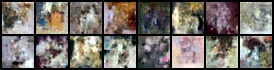

In [11]:
import torch
from diffusers import EulerDiscreteScheduler
from torchvision.utils import save_image
from PIL import Image

# --- 1. Setup Model and Sampler ---

model.eval() # Put the model in evaluation mode

# Use the Euler–Maruyama sampler (EulerDiscreteScheduler)
sampler_config = scheduler.config.copy()
if sampler_config['prediction_type'] == 'velocity':
    sampler_config['prediction_type'] = 'v_prediction' # Fix config mismatch

sampler = EulerDiscreteScheduler.from_config(sampler_config)
sampler.set_timesteps(250) # 250 denoising steps

# --- 2. Define Inference Parameters ---

# Generate 8 images of 'cat' (index 0) and 8 of 'dog' (index 1)
num_images_per_class = 8
total_images = 16

# Get the clean class tokens for inference
# We repeat each class embedding 'num_images_per_class' times
# (8, 1, H)
clean_cat_token = class_embeddings[0].unsqueeze(0).repeat(num_images_per_class, 1, 1)
# (8, 1, H)
clean_dog_token = class_embeddings[1].unsqueeze(0).repeat(num_images_per_class, 1, 1)
# (16, 1, H)
clean_c = torch.cat([clean_cat_token, clean_dog_token], dim=0)

# --- 3. Run the Denoising Loop ---

print("Generating images...")
with torch.no_grad():
    # Start with random noise
    latents = torch.randn(
        (total_images, 3, 32, 32),
        device=device
    )

    # Scale initial noise according to the sampler
    latents = latents * sampler.init_noise_sigma

    # Loop through the timesteps
    for t_step in sampler.timesteps:
        t = t_step.unsqueeze(0).repeat(total_images).to(device)

        # Scale the latents before passing them to the model
        model_input = sampler.scale_model_input(latents, t_step)

        # Predict velocity
        v_pred_img, _ = model(model_input, t, clean_c)

        # Scheduler step to get the previous sample
        latents = sampler.step(v_pred_img, t_step, latents).prev_sample

print("Generation complete.")

# --- 4. Post-process and Display ---

# Denormalize images from [-1, 1] to [0, 1]
latents = (latents + 1) / 2
latents = latents.clamp(0, 1) # Ensure values are in [0, 1]

# Save the grid of images
save_image(latents, "generated_samples.png", nrow=num_images_per_class)

# Display the image grid in Colab
print("Displaying generated images (Row 1: Cats, Row 2: Dogs)")
display(Image.open("generated_samples.png"))